In [1]:
#imports
import pandas as pd     
import matplotlib.pyplot as plt    
%matplotlib inline
import seaborn as sns    
import numpy as np
from sklearn.mixture import GaussianMixture as GMM
import os
sns.set(style="darkgrid")
from math import pi

# P1
## Fetching Data

In [2]:
# Getting all csv
# Reference: https://perials.com/getting-csv-files-directory-subdirectories-using-python/
import os
from glob import glob
PATH = "sadness/"
EXT = "*.csv"
files = [file for path, subdir, files in os.walk(PATH)
            for file in glob(os.path.join(path, EXT))]

In [3]:
#concatinating df
l = []
for f in files:
    df = pd.read_csv(f)
    df['video'] = np.full(len(df), int(os.path.basename(f)[:-4]), dtype = int)
    l.append(df)
df = pd.concat(l, ignore_index=True)

## Processing Data and Extracting features

In [4]:
#removing low confidence data
df = df[df[' success'] != 0]
df = df[df[' confidence'] > 0.8]

In [5]:
#extracting features
au = ['video', ' gaze_angle_x', ' gaze_angle_y', ' pose_Rx', ' pose_Ry', ' pose_Rz']
for x in df.columns:
    if '_r' in x and ' AU' in x:
        au.append(x)

df = df[au]

# Part 2
# Visualizing and Analyzing K-Cluster Mean

In [8]:
from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from tslearn.utils import to_time_series_dataset

a = set(df['video'])
data = []
for i in a: 
    d1 = df[df['video'] == i]
    d1 = d1.drop(columns = ['video']).interpolate().values
    data.append(d1)
X = to_time_series_dataset(data)

from tslearn.clustering import TimeSeriesKMeans
km = TimeSeriesKMeans(n_clusters=2, metric="dtw", random_state = 4)
labels = km.fit_predict(X)
centers = km.cluster_centers_
np.set_printoptions(precision=2)

In [9]:
labels

array([1, 2, 1, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 1, 1, 2, 1,
       0, 2, 2, 2, 2, 0, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 0, 1,
       2, 2, 1, 2, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 0, 2, 0, 2])

## The following Graph Shows Feature Changes With Time Series in 2 Clusters Mean

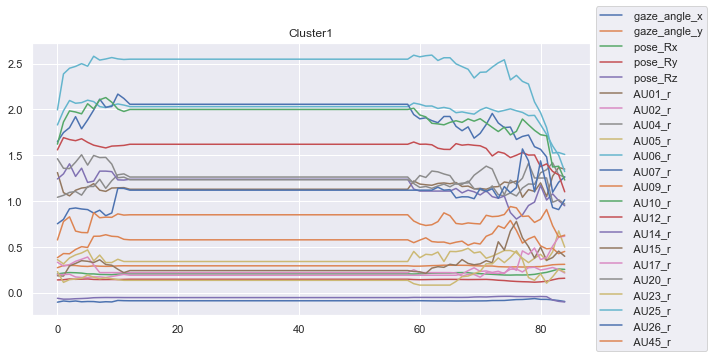

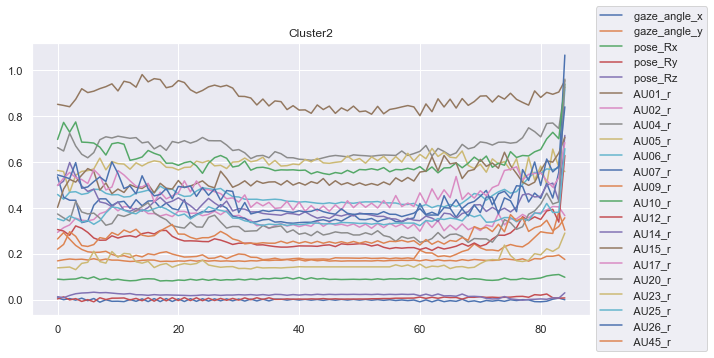

In [8]:
col = df.columns
col = col.drop('video')

cluster1 = pd.DataFrame(data=km.cluster_centers_[0], index=range(85), columns=col)
cluster2 = pd.DataFrame(data=km.cluster_centers_[1], index=range(85), columns=col)

cluster1.plot(figsize=(10,5), title='Cluster1').legend(loc='center left',bbox_to_anchor=(1.0, 0.5));
cluster2.plot(figsize=(10,5), title = 'Cluster2').legend(loc='center left',bbox_to_anchor=(1.0, 0.5));

## Getting Top Features in Each Cluster - Social Signal

In [9]:
## this can be replaced to extracted most changed feature
# topSignals = dict(cluster.max(axis=0) - cluster.min(axis=0))

In [10]:
## this can be replaced to extracted most feature with lowest min
# absClusterVal = cluster.abs()
# topSignals = dict(absClusterVal.min(axis=0))

In [11]:
# Getting feature with highest value
from collections import Counter
def getSocialSignal(cluster):
    absClusterVal = cluster.abs()
    topSignals = dict(absClusterVal.min(axis=0))
    featureChanges = Counter(topSignals).most_common(5)
#     topSignals = dict(socialSignals.max(axis=0))
#     featureChanges = Counter(topSignals).most_common(3)
    return featureChanges

## Social Signal -1
        ##Momentary emotional Cry
            -burst (increase and decrease) in mouth open(AU25), cheek raise(AU06), upper lips raiser(AU12), chin raise(AU7)

In [12]:
featureChanges1 = getSocialSignal(cluster1)
for i in featureChanges1:
    print(i)

(' AU25_r', 1.5088888888888887)
(' AU06_r', 1.322222222222222)
(' AU10_r', 1.23)
(' AU12_r', 1.1011111111111112)
(' AU07_r', 1.0955555555555554)


## Social Signal -2
        ##Frowning 
         - increase inner brow raise(AU1), brow lower(AU4), cheek raise(AU6), upperlid raise(AU5) and lip corner depress(AU15)

In [13]:
featureChanges2 = getSocialSignal(cluster2)
for i in featureChanges2:
    print(i)

(' AU01_r', 0.8024528301886792)
(' AU04_r', 0.6077358490566037)
(' AU10_r', 0.5456603773584905)
(' AU05_r', 0.4679245283018868)
(' AU15_r', 0.4024528301886791)


## Plot Significant Features

In [14]:
def plotFeatures(featureChanges, cluster, plotTitle):
    features = []
    for i in range(len(featureChanges)):
        features.append(featureChanges[i][0])
    featureCluster = cluster[features]
    featureCluster.plot(title = plotTitle).legend(loc='center left',bbox_to_anchor=(1.0, 0.5));

## Cluster1 Crying Pattern -Instantaneous
        low -> high -> low

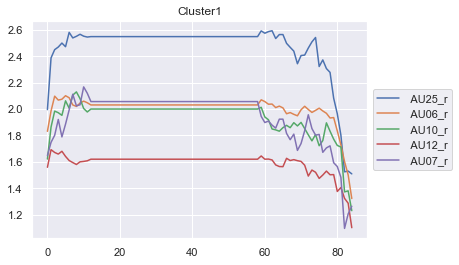

In [15]:
plotFeatures(featureChanges1, cluster1, "Cluster1")

 ## Cluster2 Frowning Pattern -Build Up
         low -> high

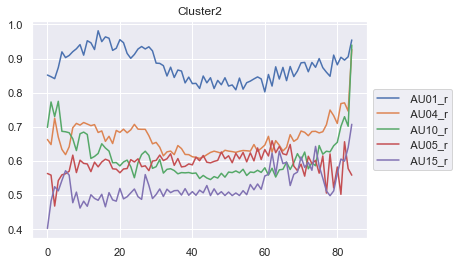

In [16]:
plotFeatures(featureChanges2, cluster2, "Cluster2")

In [17]:
from IPython.display import Image, display

videos = list(a)
for k in range(2):
    print("cluster " + str(k))
    c = np.where(labels == k)
    for i,counter in zip(c[0],range(2)):
        X = Image(url='Gif/{}.gif'.format(videos[i]))
        display(X)


cluster 0


cluster 1


# P3
## Training on images from cluster2

Extract 45 images in cluster2

I would like to do a time seriers KNN, therefore I will choose a single prominant feature from cluster2 most representative of the frowning motion, and interpolate the features in each dataset

In [18]:
featureChanges2

[(' AU01_r', 0.8024528301886792),
 (' AU04_r', 0.6077358490566037),
 (' AU10_r', 0.5456603773584905),
 (' AU05_r', 0.4679245283018868),
 (' AU15_r', 0.4024528301886791)]

I will choose AU04 (brow furrowing motion) to withdraw time series pattern from, since AU04 has a both high present value, and a distinctive time series change (high low high) in cluster2 

In [19]:
def processData(data):
    data = data[data[' success'] != 0]
    data = data[data[' confidence'] > 0.8]
    return data

def extractFeatures(data):
    data = data[' AU04_r']
    return data

In [20]:
sadnessData = []
video = list(a)
c = np.where(labels == 1)
for i,j in zip(c[0], range(45)):
    temp = df[df['video'] == video[i]]
#     temp['video'] = np.full(len(temp), video[i], dtype = int)
    temp = extractFeatures(temp)
    temp = temp.interpolate().values
    if temp.size == 0:
        continue
    sadnessData.append(temp)
# training_sad = pd.concat(sadnessData, ignore_index=True)

Extract 8 images from happiness, satisfaction, surprise, anger

In [21]:
def getData(PATH):
#     PATH = "happiness/"
    EXT = "*.csv"
    files = [file for path, subdir, files in os.walk(PATH)
                for file in glob(os.path.join(path, EXT))]
    DataList = []
    for f in files:
        temp = pd.read_csv(f)
#         temp['video'] = np.full(len(temp), int(os.path.basename(f)[:-4]), dtype = int)
        temp = extractFeatures(processData(temp))
        temp = temp.interpolate().values.tolist()
        if len(temp) < 2:
            continue
        DataList.append(temp)
#     DataList = pd.concat(DataList, ignore_index=True)
    return DataList


In [22]:
satisfactionData = getData("satisfaction/")
surpriseData = getData("surprise/")
angerData = getData("anger/")


# KNN Classification

In [23]:
from tslearn.neighbors import KNeighborsTimeSeriesClassifier
from tslearn.clustering import TimeSeriesKMeans

## Training Data -54 data
     train using 35 sadness-cluster2, 8 anger, 8 surprise, 8 satsifaction
     test using 10 sadness-cluster2, 2 anger, 2 surprise, 2 satsifaction

In [24]:
# reference: https://stackoverflow.com/questions/38064697/interpolating-a-numpy-array-to-fit-another-array
import scipy.interpolate as interp
def interpolateData(data):
    for i in range(len(data)):
        inter = interp.interp1d(np.arange(len(data[i])),data[i])
        reshapedVal = inter(np.linspace(0,len(data[i])-1,8))
        data[i] = reshapedVal.tolist()
    return data

In [25]:
import random
classifier = ['sadness']*35 + ['anger']*8 + ['surprise']*8 + ['satisfaction']*8
evaluation = ['sadness']*10 + ['anger']*2 + ['surprise']*2 + ['satisfaction']*2

Classifying using KNN

In [26]:
def calcKNN(test, training):
    clf = KNeighborsTimeSeriesClassifier(n_neighbors=1, metric="dtw")
    result = clf.fit(training,y=classifier).predict(test)
    return result

In [27]:
def evaluate(result):
    outcome = 0
    sadnessOutcome = 0
    for i in range(len(result)):
        if result[i] == evaluation[i]:
            outcome += 1
            if result[i] == 'sadness':
                sadnessOutcome += 1
    print("success rate overall {}".format(outcome/len(result)))
    print("success rate identifying social pattern {} %".format(sadnessOutcome/10))

In [28]:
# Getting Next fold for k-fold data
print("Correct Clustering:")
print(evaluation)
print("******************************")
for k in range(5):
    random.shuffle(sadnessData)
    random.shuffle(angerData)
    random.shuffle(surpriseData)
    random.shuffle(satisfactionData)

    training = sadnessData[0:35] + angerData[0:8] + surpriseData[0:8] + satisfactionData[0:8]
    training = interpolateData(training)
    test = sadnessData[35:45] + angerData[8:10] + surpriseData[8:10] + satisfactionData[8:10]

    result = calcKNN(test, training)
    evaluate(result)
    

Correct Clustering:
['sadness', 'sadness', 'sadness', 'sadness', 'sadness', 'sadness', 'sadness', 'sadness', 'sadness', 'sadness', 'anger', 'anger', 'surprise', 'surprise', 'satisfaction', 'satisfaction']
******************************
success rate overall 0.25
success rate identifying social pattern 0.4 %
success rate overall 0.3125
success rate identifying social pattern 0.5 %
success rate overall 0.5
success rate identifying social pattern 0.7 %
success rate overall 0.5
success rate identifying social pattern 0.8 %
success rate overall 0.3125
success rate identifying social pattern 0.4 %


# Final Remark

## Part 2
multidimensional DTW + K-means was successful, the clusters reflected 2 expressive displays for sadness based on cluster mean data (instantaneous) emotional crying (mouth open), and (building up) frowning/slight crying)

## Part 3
performance of KNN classification on my dataset was not successful.  Classificating sadness using the given social signal have a success rate around 0.6 for KNN, classifying overall emotions (anger, pleasure, satisfaction, sadness) using the social signal lowers down to a success rate of around 0.5. KNN in this part provides using only a signal feature time series pattern proves to be insufficient in identifying the social feature.